# Intro to Numba

Reading: https://lectures.quantecon.org/py/numba.html

* Yesterday we used NumPy to write faster, more optimized code
* This relied on something called *vectorization*
* Vectorization is about sending batches of related operations to native machine code

In [2]:
import numpy as np

z = np.arange(10000)
z_2 = np.empty_like(z)

In [3]:
%%timeit

for i, z_i in enumerate(z):
    z_2[i] = i**2

4.01 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit

z**2

3.28 µs ± 27.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


* Sometimes the algorithm you want to speed up cannot be vectorized
* Vectorization can also be memory-intensive

**Numba** is an alternative to speed up code, using **just-in-time compilation**

* Numba aims to automatically compile functions to native machine code instructions *on the fly*
* Numba needs to infer type information on all variables

Let’s consider some problems that are difficult to vectorize

Say we want to generate a time series from a difference equation

$$
x_{t+1} = 4 x_t (1 − x_t)
$$

with $x_0 = 0.1$

This is difficult to vectorize because each calculation relies on the previous step

In [6]:
def qm(x0, n):
    x = np.empty(n+1)  # Array to store each x_t
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

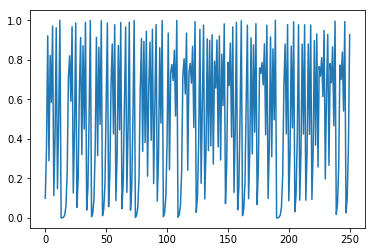

In [8]:
import matplotlib.pyplot as plt

plt.plot(qm(0.1, 250))
plt.show()

In [9]:
%%timeit

qm(0.1, 250)

163 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


To speed this up using Numba...

In [10]:
from numba import jit

@jit
def qm_numba(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

In [11]:
%%timeit

qm_numba(0.1, 250)

The slowest run took 5.84 times longer than the fastest. This could mean that an intermediate result is being cached.
2.23 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Which run is the slowest? Why?

**Exercise:** Write a function called `generate_AR1` that takes `mu`, `rho` and `T` as arguments, and use Numba to just-in-time compile it


$$
y_{t+1} = \mu + \rho y_t + \varepsilon_t \quad \quad \varepsilon_t \sim (0, 1)
$$

Where:
* $\rho$ is the persistence parameter
* $\varepsilon_t$ is an i.i.d random shock

* `mu` and `rho` should be positional arguments
* `T` should be a keyword argument with a default value of 200
* Let $y_0 = 10$

The function should **return** an AR(1) series

In [19]:
# @jit
def generate_AR1(mu, rho, T=20000):
    
    y = np.empty(T)        # Array to hold time series
    y[0] = 10              # Starting value of y
    
    for t in range(T):
        e = np.random.normal()
        new_y = mu + rho * y[t-1] + e
        y[t] = new_y
        
    return y

In [20]:
%%timeit
generate_AR1(5, 0.8)

41.4 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Numba is able to speed up our code using *type inference*
* When compiling, Numba infers the types of variables and generates machine code specialized to that type of data

**Try to avoid using global variables with Numba**

Consider this example

In [27]:
a = 1

@jit
def add_x(x):
    a = 1
    return a + x

add_x(10)

11

In [29]:
jitted_add_x = jit(add_x)

In [30]:
jitted_add_x(10)

11

In [28]:
a = 2
add_x(10)

11

**Numba doesn't work with many packages**

* To use Numba with other packages, like NumPy, these packages must also be jit-compiled
* In the exercise above, you were able to use NumPy's random subpackage to generate draws from the normal distribution
* NumPy maintains a list of Numba-supported functions here: https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html
* Many standard packages, like SciPy, are not yet jit-compiled, and so cannot be used inside a jitted function

In [35]:
from scipy.integrate import quad


def compute_integral(n):
    return quad(lambda x: x**(1/n), 0, 1) 

In [36]:
compute_integral(4)

(0.8000000000000004, 8.881784197001256e-16)

In [37]:
@jit
def compute_integral(n):
    return quad(lambda x: x**(1/n), 0, 1)

In [38]:
compute_integral(4)

UnsupportedError: Failed in object mode pipeline (step: ensure IR is legal prior to lowering)
[1mNumba encountered the use of a language feature it does not support in this context: <creating a function from a closure> (op code: make_function not supported). If the feature is explicitly supported it is likely that the result of the expression is being used in an unsupported manner.
[1m
File "<ipython-input-37-1feae166751b>", line 3:[0m
[1mdef compute_integral(n):
[1m    return quad(lambda x: x**(1/n), 0, 1)
[0m    [1m^[0m[0m
[0m
Unsupported functionality was found in the code Numba was trying to compile.

If this functionality is important to you please file a feature request at:
https://github.com/numba/numba/issues/new


* A way around this could be to split up your code into smaller functions and only `jit` sections where possible

### Another example

Suppose we want to maximize the function 

$$ f(x, y) = \frac{\cos \left(x^2 + y^2 \right)}{1 + x^2 + y^2} + 1$$

using brute force --- searching over a grid of $(x, y)$ pairs.

In [39]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

<IPython.core.display.Javascript object>


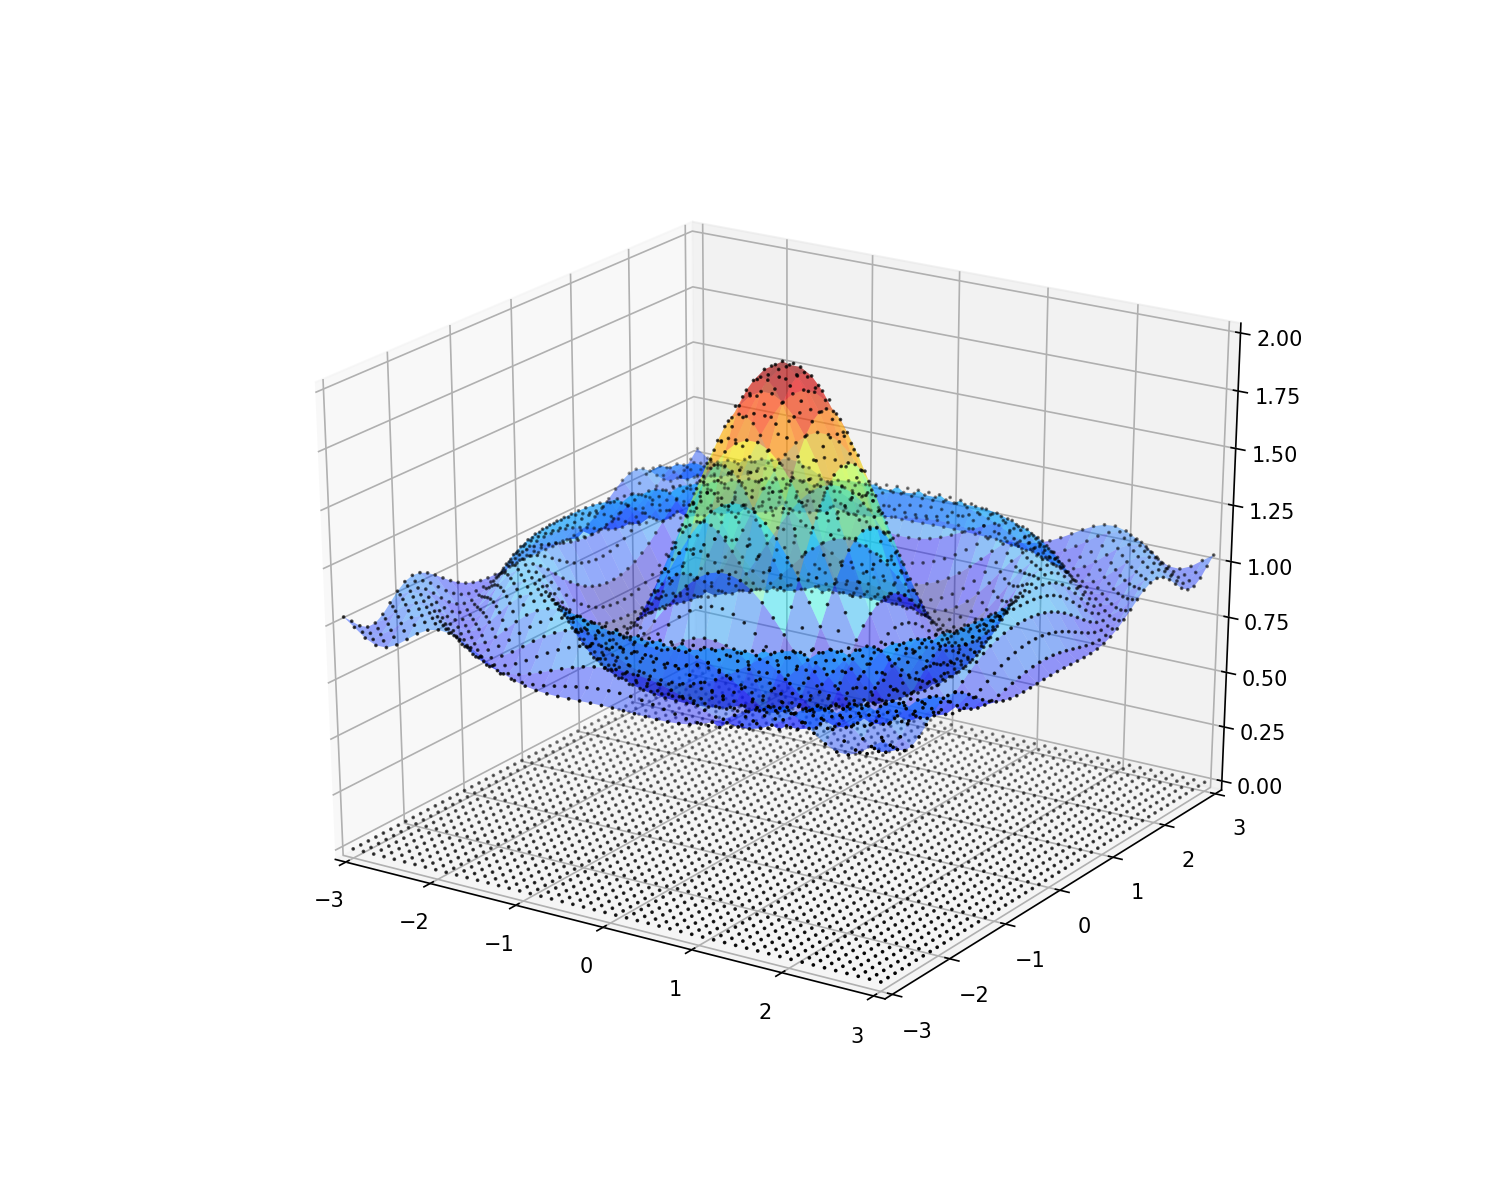

In [40]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
%matplotlib notebook

gridsize = 50
gmin, gmax = -3, 3
xgrid = np.linspace(gmin, gmax, gridsize)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

# === plot value function === #
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.4,
                linewidth=0.05)


ax.scatter(x, y, c='k', s=0.6)

ax.scatter(x, y, f(x, y), c='k', s=0.6)

ax.view_init(25, -57)
ax.set_zlim(-0, 2.0)
ax.set_xlim(gmin, gmax)
ax.set_ylim(gmin, gmax)

plt.show()

We can do this with vectorization....

In [44]:
grid = np.linspace(-3, 3, 10_000)
x, y = np.meshgrid(grid, grid)
%time np.max(f(x, y))

CPU times: user 4.08 s, sys: 5.78 s, total: 9.85 s
Wall time: 7.19 s


1.999999819964011

**Exercise:** write a jitted function (not vectorized) to find the maximum over the grid using brute force -- how does this compare to vectorization?

In [43]:
@jit
def find_max():
    m = -np.inf
    for x in grid:
        for y in grid:
            z = np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1
            if z > m:
                m = z
    return m

%time find_max()

CPU times: user 1.38 s, sys: 6.89 ms, total: 1.39 s
Wall time: 1.39 s


1.999999819964011